In [1]:
%load_ext autoreload
%autoreload 2
%config Completer.use_jedi = False

In [2]:
import matplotlib.pyplot as plt
import numpy as np
import vice
import sys
sys.path.append("../")
from vice_utils import calculate_z, sample_stars, filter_stars, show_stars, R_to_zone, zone_to_R, show_at_R_z
import apogee_analysis as aah
from plotting import fig_saver

/home/daniel/surp/VICE/vice/__init__.py:141: UserWarning: Using un-released version of VICE
  warnings.warn("Using un-released version of VICE", UserWarning)


In [10]:
sf = fig_saver("figures")

In [4]:
def load_model(name):
    """Loads a vice.milkyway model output at the location name
    
    Parameters
    ----------
    name : str
        the name of the model to load
    
    Returns
    -------
    vice.multioutput file
    """
    milkyway = vice.output(name)
    milkyway.stars["abs_z"] = calculate_z(milkyway)
    milkyway.stars["R_origin"] = zone_to_R(np.array(milkyway.stars["zone_origin"]))
    milkyway.stars["R_final"] = zone_to_R(np.array(milkyway.stars["zone_final"]))
    if "[c/o]" not in milkyway.stars.keys():
        milkyway.stars["[c/o]"] = -np.array(milkyway.stars["[o/c]"]) 
    if "[c/n]" not in milkyway.stars.keys():
        milkyway.stars["[c/n]"] = -np.array(milkyway.stars["[n/c]"])
    return milkyway

In [6]:
# read in all models
import surp #needed to load in picked function
models = {}
output_dir = "output/"
model_names = ["cristallo11", "karakas10", "ventura13", "karakas16", "analytic", "cristallo11_amplified"]
model_names_c = ["cristallo11", "cristallo11_multithreaded", "cristallo11_8stars"]
model_names = ["cristallo11", "cristallo11_static", "cristallo11_lateburst",   "cristallo11_J22", "cristallo11_reduced_eta"]
for name in model_names:
    models[name] = load_model(output_dir + name)

/home/daniel/surp/VICE/vice/core/outputs/output.py:131: UserWarning: agb n yield not encoded with output. Assuming the current yield setting, which may not reflect the yield setting at the time the simulation was ran.
  self.__c_version = c_output(name)
/home/daniel/surp/VICE/vice/core/outputs/output.py:131: UserWarning: agb fe yield not encoded with output. Assuming the current yield setting, which may not reflect the yield setting at the time the simulation was ran.
  self.__c_version = c_output(name)
/home/daniel/surp/VICE/vice/core/outputs/output.py:131: UserWarning: agb o yield not encoded with output. Assuming the current yield setting, which may not reflect the yield setting at the time the simulation was ran.
  self.__c_version = c_output(name)


In [7]:
# sample the stars from each model to show accurate representations
# of the stellar populations
max_zone = 155
stars = {}
solar_neighborhood_stars = {}
for name, model in models.items():
    # remove numerical artifacts
    s = model.stars.filter("zone_origin", "<", max_zone)
    stars[name] = sample_stars(s, num=10_000)
    solar_neighborhood_stars[name] = sample_stars(filter_stars(s, 7, 9, 0, 0.5), num=10_000)

In [8]:
# not very useful

def annulus_average(output, name, zone_min, zone_max):
    return np.average(np.array([output.zones["zone%i" % i].history[name] 
                                for i in range(zone_min, zone_max)]
                              ),
                      axis=0)

def show_annulus_average(output, x, y, c=None, R_min=7, R_max=9, **kwargs):
    zone_min = R_to_zone(R_min)
    zone_max = R_to_zone(R_max)
    x_values = annulus_average(output, x, zone_min, zone_max)
    y_values = annulus_average(output, y, zone_min, zone_max)
    
    if c is None:
        plt.plot(x_values, y_values, **kwargs)
    else:
        c_values = annulus_average(output, c, zone_min, zone_max)
        plt.scatter(x_values, y_values, c=c_values, **kwargs)
        plt.colorbar()
    plt.xlabel(x)
    plt.ylabel(y)
    
def show_annulus(output, x, y, c=None, R_min=0, R_max=15.4, **kwargs):
    # modified to just show values at present_day
    zone_min = R_to_zone(R_min)
    zone_max = R_to_zone(R_max)
    x_values = [output.zones["zone%i" % i].history[x][-1] for i in range(zone_min, zone_max)]
    y_values = [output.zones["zone%i" % i].history[y][-1] for i in range(zone_min, zone_max)]
    
    if c is None:
        plt.plot(x_values, y_values, **kwargs)
    else:
        c_values = [output.zones["zone%i" % i].history[c][-1] for i in range(zone_min, zone_max)]
        plt.scatter(x_values, y_values, c=c_values, **kwargs)
        plt.colorbar()
    plt.xlabel(x)
    plt.ylabel(y)

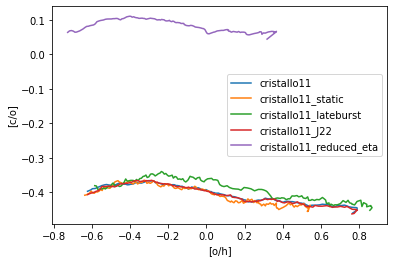

In [11]:
for name, model in models.items():
    show_annulus(model, "[o/h]", "[c/o]", label=name,)
plt.legend()
sf("cooh_gas")


In [12]:
def for_each_model(func, sfh="insideout"):
    names = model_names
    
    if sfh=="both":
        for name, model in models.items():
            func(model, name)
    elif sfh=="insideout":
        for name in names:
            func(models[name], name)
    else:
        for name in names:
            n = name + "_" + sfh
            func(models[n], n)

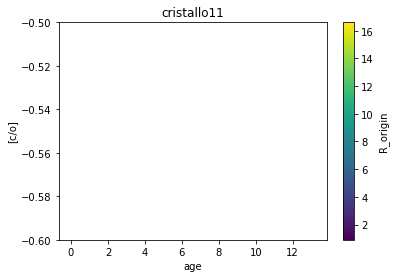

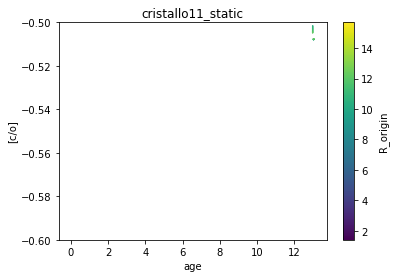

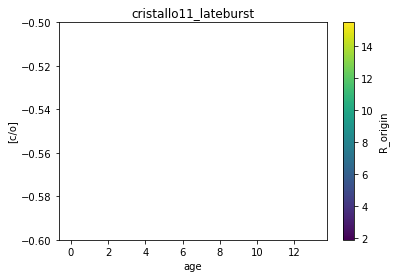

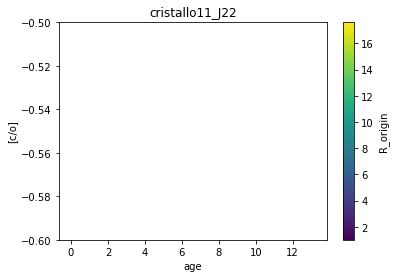

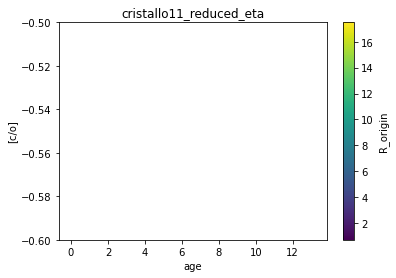

In [24]:
def plot_age_c_o(model, name):
    show_stars(filter_stars(model.stars, 7, 9, 0, 0.5), "age", "[c/o]", c="R_origin", s=0.1)
    plt.title(name)
    plt.ylim(-0.6, -0.5)
    
    sf("co_age_stars_" + name)

    
    plt.show()

    
for_each_model(plot_age_c_o)

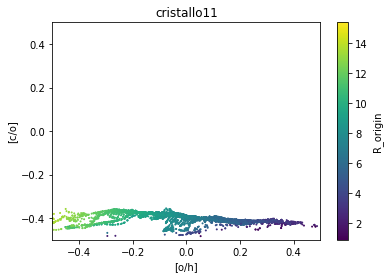

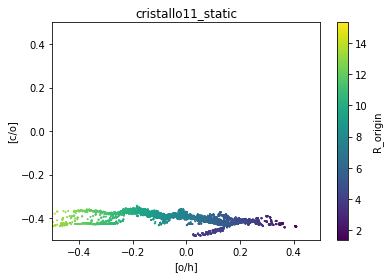

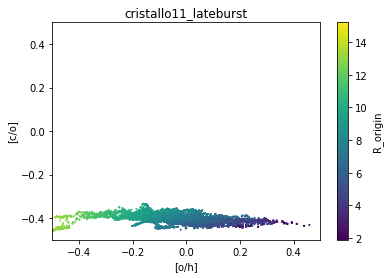

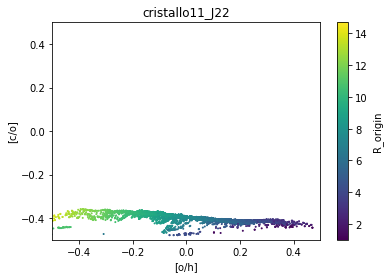

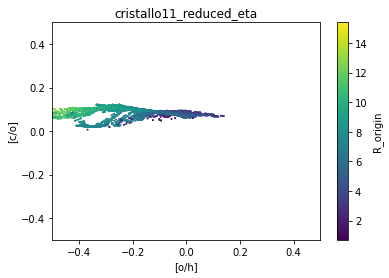

In [25]:
def plot_cooh(model, name):
    show_stars(solar_neighborhood_stars[name], "[o/h]", "[c/o]", c="R_origin")
    plt.title(name)
    plt.ylim(-0.5, 0.5)
    plt.xlim(-0.5,0.5)
    
    sf("cooh_stars_" + name)

    
    plt.show()
    
    
for_each_model(plot_cooh)

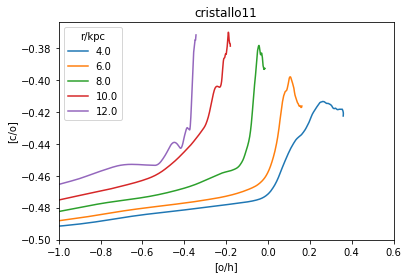

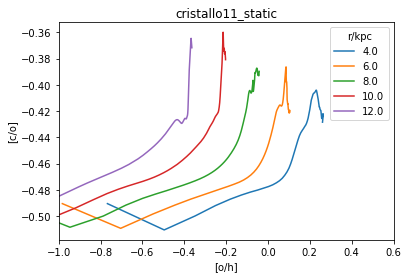

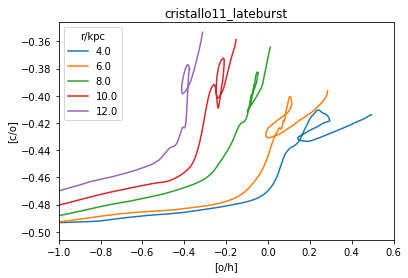

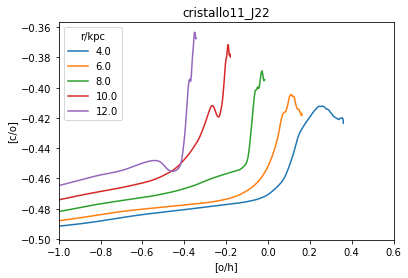

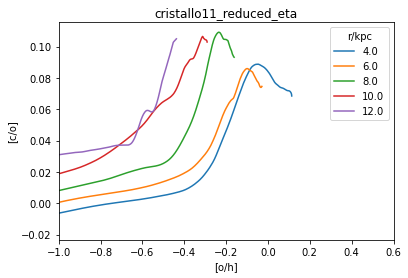

In [15]:
def cooh_age(model, name):
    for i in np.array([4, 6, 8, 10, 12])*10:
        show_annulus_average(model, "[o/h]", "[c/o]", R_min=i/10-0.5, R_max=i/10+0.5, label=i/10)
    plt.legend(title="r/kpc")
    plt.xlim(-1,0.6)
    plt.title(name)
    
    sf("cooh_gas_" + name)

    
    plt.show()

for_each_model(cooh_age)

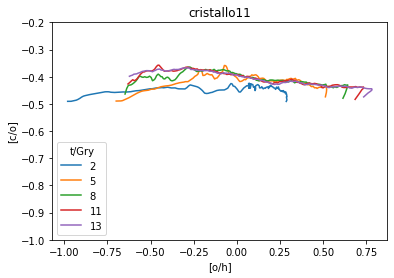

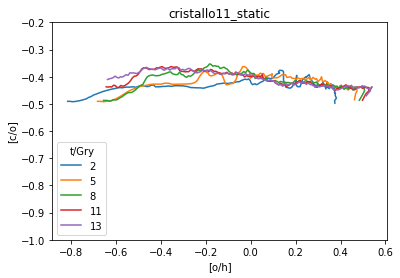

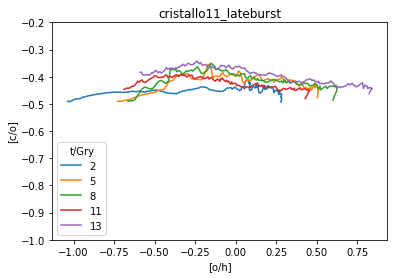

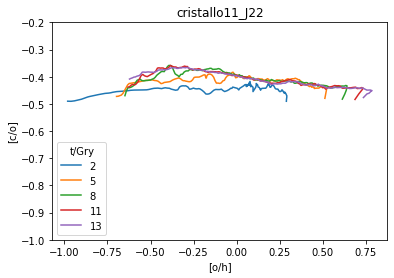

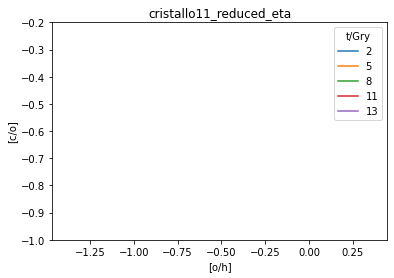

In [16]:
def cooh_R(model, name):
    for t in [2, 5, 8, 11, 13]:
        times = np.array(model.zones["zone0"].history["time"])
        j = int(100*t)
        j = np.arange(len(times))[times == t][0]

        y = np.zeros(155)
        x = np.zeros(155)
        R = np.arange(0, 15.5, 0.1)

        for i in range(155):
            y[i] = model.zones["zone%i" % i].history["[c/o]"][j]
            x[i] = model.zones["zone%i" % i].history["[o/h]"][j]
        plt.plot(x, y, label=t)

    plt.legend(title="t/Gry")
    #plt.xlim(-1,0.6)
    plt.title(name)
    plt.ylim(-1, -0.2)
    plt.xlabel("[o/h]")
    plt.ylabel("[c/o]")
    
    name = "co_age_gas_" + name
    plt.savefig(name + ".jpeg")
    plt.savefig(name + ".pdf")
    
    plt.show()
    
for_each_model(cooh_R)

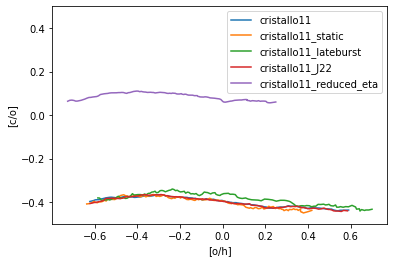

In [26]:
def cooh(model, name):
    t = 13.2
    j = int(100*t)
    
    j = -1
    
    i_min = 20
    i_max = 155
    y = np.zeros(i_max - i_min)
    x = np.zeros(i_max - i_min)

    for i in range(i_max - i_min):
        y[i] = model.zones["zone%i" % (i+i_min)].history["[c/o]"][j]
        x[i] = model.zones["zone%i" % (i+i_min)].history["[o/h]"][j]
    plt.plot(x, y, label=name)
    plt.ylim(-0.5, 0.5)
    plt.xlabel("[o/h]")
    plt.ylabel("[c/o]")
    
for_each_model(cooh)
plt.legend()
    
name = "cooh_gas_models"
plt.savefig(name + ".jpeg")
plt.savefig(name + ".pdf")
    


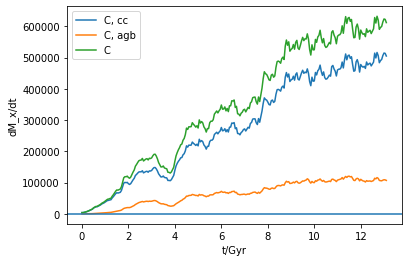

In [18]:
def agb_to_ccsn(model, name):
    agb_ratio = 0.002/0.015 #y_agb_c/y_agb_o
    h = model.zones["zone70"].history
    times = np.array(h["time"][:-1])
    eta = np.array(h["eta_0"][:-1])
    r = np.array(h["r_eff"][:-1])
    m_star = np.array(h["mstar"][:-1])
    m_o = np.array(h["mass(o)"])
    m_c = np.array(h["mass(c)"])
    z_o = np.array(h["z(o)"][:-1])
    z_c = np.array(h["z(c)"][:-1])
    dt = times[1] - times[0]
    
    d_m_o = m_o[1:] - m_o[:-1]
    d_m_c = m_c[1:] - m_c[:-1]
    
    o_cc_dot = d_m_o + (1+eta-r)*m_star * z_o
    c_cc_dot = agb_ratio * o_cc_dot
    c_agb_dot = d_m_c + (1+eta - r)*m_star * z_c - c_cc_dot
    
    plt.plot(times, c_cc_dot, label="C, cc")
    plt.plot(times, c_agb_dot, label="C, agb")
    plt.plot(times, d_m_c + (1+eta - r)*m_star * z_c, label="C")
    #plt.plot(times, do_dt, label="O")
    # plt.plot(times, o_cc_dot/0.015, label="me")
    # plt.plot(times, m_star, label="c")
    # plt.plot(h["time"], h["mgas"])

agb_to_ccsn(models["cristallo11_static"], "hi")
plt.legend()
plt.xlabel("t/Gyr")
plt.ylabel("dM_x/dt")
plt.axhline(0)

In [19]:
def means_star_value(stars, value, bin_name, bins):
    N = len(bins) - 1
    means = np.zeros(N)
    sds = np.zeros(N)
    for i in range(N):
        filtered_stars = stars.filter(bin_name, ">=", bins[i]).filter(bin_name, "<", bins[i + 1])
        means[i] = np.mean(filtered_stars[value])
        sds[i] = np.std(filtered_stars[value])
    
    return means, sds

/home/daniel/.local/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3419: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/daniel/.local/lib/python3.8/site-packages/numpy/core/_methods.py:188: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/home/daniel/.local/lib/python3.8/site-packages/numpy/core/_methods.py:261: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/daniel/.local/lib/python3.8/site-packages/numpy/core/_methods.py:221: RuntimeWarning: invalid value encountered in true_divide
  arrmean = um.true_divide(arrmean, div, out=arrmean, casting='unsafe',
/home/daniel/.local/lib/python3.8/site-packages/numpy/core/_methods.py:253: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


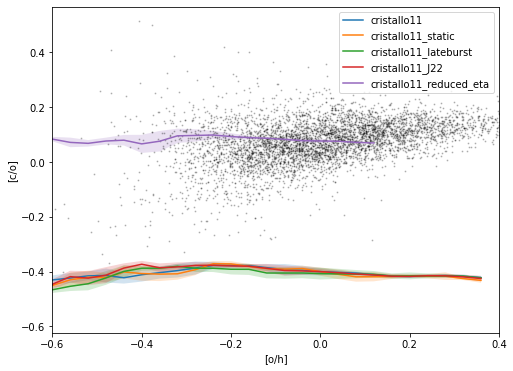

In [20]:
plt.figure(figsize=(8,6))
N = len(list(stars.keys()))
x_min = -0.6
x_max = 0.4
for i in range(N):
    name = list(stars.keys())[i]
    s = solar_neighborhood_stars[name]
    dx = 0.04
    bins = np.arange(x_min, x_max+dx, dx)
    y, yerr= means_star_value(s, "[c/o]", "[o/h]", bins)
    plt.plot(bins[:-1], y, label=name)
    plt.fill_between(bins[:-1], y-yerr, y+yerr, alpha=0.2)

plt.legend()
plt.xlabel("[o/h]")
plt.ylabel("[c/o]")
# plt.title("R = 7-9 kpc, |z| = 0-0.5 kpc")
plt.xlim(x_min,x_max)

aah.plot_apogee_cooh(c="black")
sf("cooh_star_models")


/home/daniel/.local/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3419: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/daniel/.local/lib/python3.8/site-packages/numpy/core/_methods.py:188: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/home/daniel/.local/lib/python3.8/site-packages/numpy/core/_methods.py:261: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/daniel/.local/lib/python3.8/site-packages/numpy/core/_methods.py:221: RuntimeWarning: invalid value encountered in true_divide
  arrmean = um.true_divide(arrmean, div, out=arrmean, casting='unsafe',
/home/daniel/.local/lib/python3.8/site-packages/numpy/core/_methods.py:253: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/home/daniel/.local/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3419: RuntimeWarning:

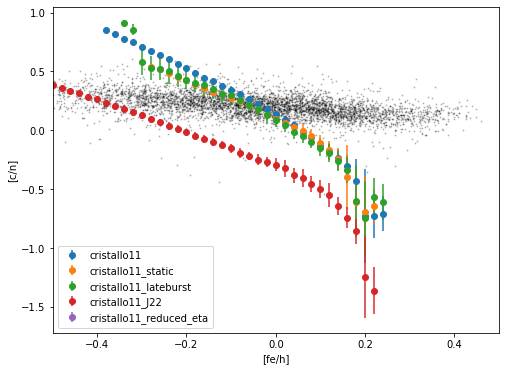

In [21]:
plt.figure(figsize=(8,6))
for name, s in stars.items():
    bins = np.arange(-0.6, 0.4, 0.02)
    y, yerr= means_star_value(s, "[fe/h]", "[c/n]", bins)
    plt.errorbar(bins[:-1], y, yerr=yerr, label=name, fmt="o")

plt.legend()
plt.xlabel("[fe/h]")
plt.ylabel("[c/n]")
aah.plot_apogee_cnfe(c="black")
plt.xlim(-0.5, 0.5)


sf("cn_fe_stars_models")


In [ ]:
# plot c/n vs age color=fe/h
# c/n as func on fe/h should be age independent

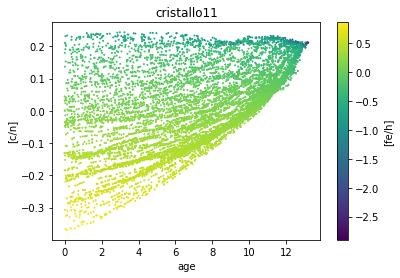

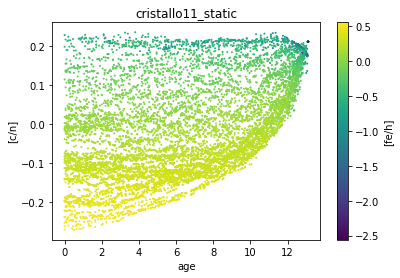

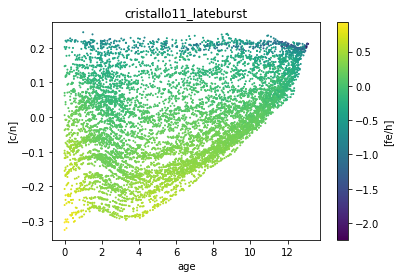

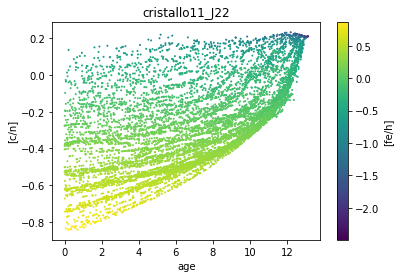

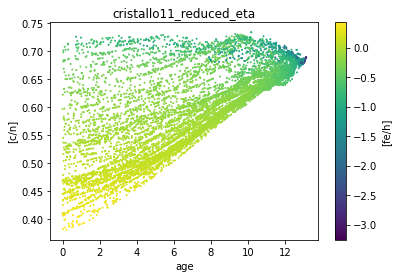

In [22]:
for name, st in stars.items():
    show_stars(st, "age", "[c/n]", c="[fe/h]")
    plt.title(name)
    plt.show()

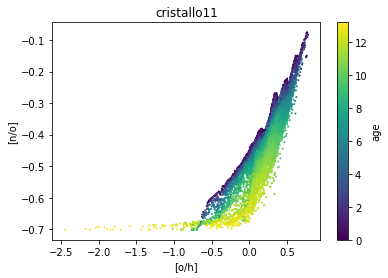

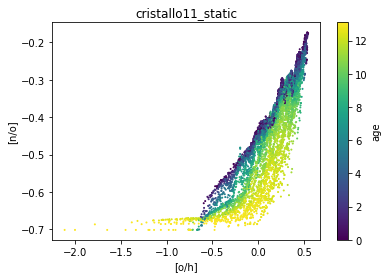

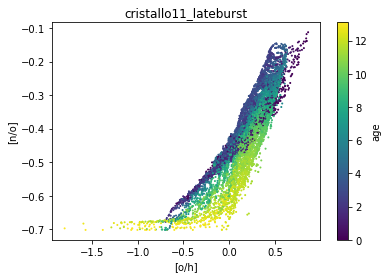

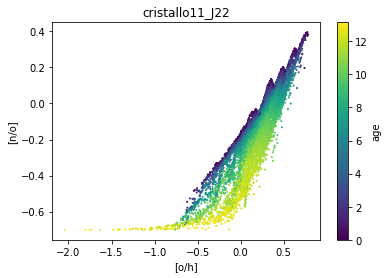

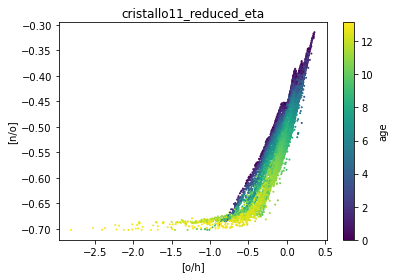

In [23]:
for name, st in stars.items():
    show_stars(st, "[o/h]", "[n/o]", c="age")
    plt.title(name)
    plt.show()